# Data Loading and Preprocessing

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
import pandas as pd

In [2]:
seed = 42

if (torch.cuda.is_available()):
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print("Running on GPU")
else:
    device = torch.device("cpu")
    torch.manual_seed(seed)
    print("Running on CPU")

Running on GPU


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_dir = './food-101'
full_dataset = datasets.Food101(root=dataset_dir, split='train', download=True, transform=transform)
classes = pd.DataFrame(full_dataset.classes, columns=['class'])
num_images_per_class = len(full_dataset) // len(full_dataset.classes)

print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Number of images: {len(full_dataset)}")
print(f"Number of images per class: {num_images_per_class}")
print("Full dataset downloaded successfully")

100%|██████████| 4996278331/4996278331 [03:46<00:00, 22055098.77it/s]


Extracting ./food-101/food-101.tar.gz to ./food-101
Number of classes: 101
Number of images: 75750
Number of images per class: 750
Full dataset downloaded successfully


In [4]:
print("All classes:")
classes

All classes:


,class
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare
...,...
96,tacos
97,takoyaki
98,tiramisu
99,tuna_tartare


In [5]:
num_filtered_classes = 20

classes_to_keep = full_dataset.classes[:num_filtered_classes]
classes_to_keep_df = pd.DataFrame(classes_to_keep, columns=['class'])

print("Filtered classes:")
classes_to_keep_df

Filtered classes:


,class
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare
5,beet_salad
6,beignets
7,bibimbap
8,bread_pudding
9,breakfast_burrito


In [91]:
# Filter the dataset to keep only the first 20 classes
try:
  filtered_dataset = torch.load('filtered_dataset.pth')
  print("Filtered dataset loaded successfully")
except:
  indices_to_keep = [i for i, (_, class_idx) in enumerate(full_dataset) if full_dataset.classes[class_idx] in classes_to_keep]
  filtered_dataset = torch.utils.data.Subset(full_dataset, indices_to_keep)

# Split the filtered data into training and validation sets
total_train_and_val_size = num_filtered_classes * num_images_per_class
train_size = int(total_train_and_val_size * 0.8)
val_size = int(total_train_and_val_size * 0.2)
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Filtered dataset loaded successfully
Number of training images: 12000
Number of validation images: 3000


In [7]:
# Filtering takes a long time, so save the filtered dataset
torch.save(filtered_dataset, 'filtered_dataset.pth')
print("Filtered dataset saved successfully")

Filtered dataset saved successfully


In [8]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualize some samples
def visualize_samples(loader, num_samples=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image = denormalize(images[i], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        image = image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.clip(image, 0, 1))
        plt.title(full_dataset.classes[labels[i]])
        plt.axis('off')
    plt.show()

In [9]:
def create_dataloaders(batch_size):
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print("DataLoaders created successfully")
    return trainloader, valloader

DataLoaders created successfully


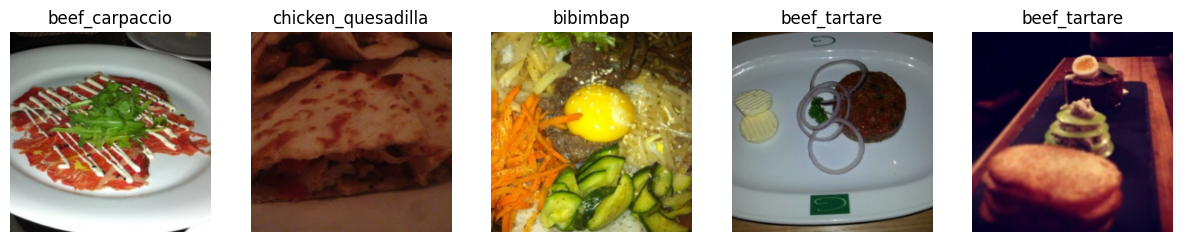

In [10]:
trainloader, valloader = create_dataloaders(64)

visualize_samples(trainloader, num_samples=5)

In [11]:
# Load the test dataset
test_dataset = datasets.Food101(root=dataset_dir, split='test', download=True, transform=transform)
num_images_per_class_test = len(test_dataset) // len(test_dataset.classes)

print(f"Number of classes: {len(test_dataset.classes)}")
print(f"Number of images: {len(test_dataset)}")
print(f"Number of images per class: {num_images_per_class_test}")
print("Full dataset downloaded successfully")

Number of classes: 101
Number of images: 25250
Number of images per class: 250
Full dataset downloaded successfully


In [92]:
try:
  filtered_test_dataset = torch.load('filtered_test_dataset.pth')
  print("Filtered test dataset loaded successfully")
except:
  test_indices_to_keep = [i for i, (_, class_idx) in enumerate(test_dataset) if test_dataset.classes[class_idx] in classes_to_keep]
  filtered_test_dataset = torch.utils.data.Subset(test_dataset, test_indices_to_keep)

test_size = 2000
filtered_test_dataset, _ = random_split(filtered_test_dataset, [test_size, len(filtered_test_dataset) - test_size])
print(f"Number of test images: {len(filtered_test_dataset)}")

Filtered test dataset loaded successfully
Number of test images: 2000


In [13]:
torch.save(filtered_test_dataset, 'filtered_test_dataset.pth')
print("Filtered test dataset saved successfully")

Filtered test dataset saved successfully


In [14]:
testloader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=False)
print("Test DataLoader created successfully")

Test DataLoader created successfully


# Model

In [93]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm

def initialize_model(layers_to_unfreeze):
  # Load pre-trained model & freeze the layers
  model = resnet18(weights=ResNet18_Weights.DEFAULT)

  if layers_to_unfreeze == 0:
    print('Freeze all layers')
    for param in model.parameters():
      param.requires_grad = False
  elif layers_to_unfreeze < 18:
    print('Freeze all but the last n layers')
    for param in list(model.parameters())[:-layers_to_unfreeze]:
      param.requires_grad = False
  elif layers_to_unfreeze >= 18:
    print('Unfreeze all the layers')
    for param in model.parameters():
      param.requires_grad = True

  # Replace the last fully connected layer with a 20-classes layer (since we have chosen to filter out 20 classes)
  features = model.fc.in_features
  model.fc = nn.Sequential(
    nn.Dropout(0.5), # helped improve the loss
    nn.Linear(features, 20)
  )

  # Move the model to GPU if available
  if torch.cuda.is_available():
      device = torch.device("cuda")
      model = model.to(device)

  return model

In [94]:
import torch.optim as optim
from tqdm import tqdm

def train_model(trainloader, valloader, lr, epochs=10, momentum=0, best_val_loss=1000.00,layers_to_unfreeze=0):
    model = initialize_model(layers_to_unfreeze)
    criterion = nn.CrossEntropyLoss()

    # by default use Adam
    if momentum == 0:
        optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    iteration_losses = []
    iteration_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_running_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        interval_running_loss = 0.0
        interval_correct = 0
        interval_total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_running_loss += loss.item()
            interval_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_total += labels.size(0)
            epoch_correct += (predicted == labels).sum().item()

            interval_total += labels.size(0)
            interval_correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                iteration_loss = interval_running_loss / 100
                iteration_accuracy = 100 * interval_correct / interval_total
                print(f'[Epoch {epoch+1}, Iteration {i+1}] Training loss: {iteration_loss:.4f}, Training accuracy: {iteration_accuracy:.2f}%')
                iteration_losses.append(iteration_loss)
                iteration_accuracies.append(iteration_accuracy)
                interval_running_loss = 0.0
                interval_correct = 0
                interval_total = 0

        epoch_loss = epoch_running_loss / len(trainloader)
        epoch_accuracy = 100 * epoch_correct / epoch_total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation at the end of the epoch
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(valloader)
        epoch_val_accuracy = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        print(f'\n>> Epoch {epoch+1}, Validation loss: {epoch_val_loss:.4f}, Validation accuracy: {epoch_val_accuracy:.2f}%')

        if epoch_val_loss < best_val_loss:
            print(f'>>>> New best model found with validation loss: {epoch_val_loss:.4f}')
            print(f'>>>> Learning rate: {lr}, Epochs: {epochs}')
            if momentum == 0:
              print(f'>>>> Optimizer: Adam')
            else:
              print(f'>>>> Optimizer: SGD with momentum {momentum}')
            print(f'>>>> Layers unfrozen: {layers_to_unfreeze}')
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_loss, iteration_losses, iteration_accuracies


# Training

## First Attempt

In [14]:
# from tqdm import tqdm

# train_losses = []
# train_accuracy = []
# val_losses = []
# val_accuracy = []

# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# model = resnet18(weights=ResNet18_Weights.DEFAULT)

# for param in model.parameters():  # Freeze all but the last 5 layers
#   param.requires_grad = False

# # Replace the last fully connected layer with a 20-classes layer
# features = model.fc.in_features
# model.fc = nn.Linear(features, 20)

# # Move the model to GPU if available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     model = model.to(device)


# # Train the model - write the training loop
# '''
# in the loop you need to keep track of training and validation accuracy.
# Print the training & validation loss & accuracy after every epoch.

# Remember when you evaluate the model on val or test set, set the model to eval
# mode, and trun off graients requirement. Once you're done, set the model back to
# train mode
# '''
# for epoch in tqdm(range(10)):  # loop over the dataset multiple times

#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#         # calculate training accuracy
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # print & accumulate training statistics (loss & accuracy) every 100 iterations
#         if i % 100 == 99:
#             print(f'[Epoch {epoch+1}, Iteration {i+1}] loss: {running_loss / 100:.4f}, accuracy: {100 * correct / total:.2f}%')
#             train_losses.append(running_loss / 100)
#             train_accuracy.append(100 * correct / total)
#             running_loss = 0.0
#             correct = 0
#             total = 0

#     # train_loss = running_loss / len(trainloader)
#     # train_acc = 100 * correct / total
#     # train_losses.append(train_loss)
#     # train_accuracy.append(train_acc)

#     # Validation at the end of the epoch
#     # set mode to eval mode & tell torch no gradients are required.
#     model.eval()

#     # define any valuable you need to track here <<<<<
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0

#     with torch.no_grad():

#       # loop through the data and find accuracy and loss for all val data
#       for data in valloader:
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         val_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         val_total += labels.size(0)
#         val_correct += (predicted == labels).sum().item()

#     epoch_val_loss = val_loss / len(valloader)
#     epoch_val_accuracy = 100 * val_correct / val_total
#     val_losses.append(epoch_val_loss)
#     val_accuracy.append(epoch_val_accuracy)


#     # set the model back to train mode
#     model.train()

# print('Finished Training')
# # -----------------------------------------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] loss: 2.4029, accuracy: 30.86%


 10%|█         | 1/10 [01:22<12:21, 82.37s/it]

[Epoch 2, Iteration 100] loss: 1.4533, accuracy: 60.12%


 20%|██        | 2/10 [02:43<10:54, 81.75s/it]

[Epoch 3, Iteration 100] loss: 1.2566, accuracy: 63.56%


 30%|███       | 3/10 [04:05<09:31, 81.60s/it]

[Epoch 4, Iteration 100] loss: 1.1635, accuracy: 65.98%


 40%|████      | 4/10 [05:28<08:12, 82.15s/it]

[Epoch 5, Iteration 100] loss: 1.0997, accuracy: 67.45%


 50%|█████     | 5/10 [06:49<06:49, 81.90s/it]

[Epoch 6, Iteration 100] loss: 1.0577, accuracy: 68.27%


 60%|██████    | 6/10 [08:10<05:26, 81.69s/it]

[Epoch 7, Iteration 100] loss: 1.0127, accuracy: 69.91%


 70%|███████   | 7/10 [09:31<04:04, 81.41s/it]

[Epoch 8, Iteration 100] loss: 1.0004, accuracy: 70.00%


 80%|████████  | 8/10 [10:53<02:43, 81.52s/it]

[Epoch 9, Iteration 100] loss: 0.9888, accuracy: 69.97%


 90%|█████████ | 9/10 [12:14<01:21, 81.51s/it]

[Epoch 10, Iteration 100] loss: 0.9748, accuracy: 70.91%


100%|██████████| 10/10 [13:35<00:00, 81.58s/it]

Finished Training


# Hyperparameter Tuning

We will be tuning the following:

* learning rates
* batch sizes
* number of epochs
* SGD optimizer or Adam
* number of hidden layers to unfreeze in the model

I went back-and-forth a number of times. The version below is the final version of the function.


In [62]:
# set a high best_val_loss value so that by default the model can take its best value and return it
def tune_model(learning_rates, batch_sizes, epochs_list, momentum_list, layers_to_unfreeze, best_val_loss=1000.00):

  # check if all of the lists that are passed as params are of the same length
  assert len(learning_rates) == len(batch_sizes) == len(epochs_list) == len(momentum_list) == len(layers_to_unfreeze), "All lists must have the same length"

  experiment_results = []

  # Run experiments
  for index, lr in enumerate(learning_rates):
      batch_size = batch_sizes[index]
      epochs = epochs_list[index]
      momentum = momentum_list[index]
      layers_to_unfreeze_value = layers_to_unfreeze[index]

      print(f'Running experiment with lr={lr}, batch_size={batch_size}, epochs={epochs}')
      if momentum > 0:
          print(f'Using SGD with momentum: {momentum}')
      else:
          print(f'Using Adam')
      print(f'Unfreezing {layers_to_unfreeze_value} layers')

      trainloader, valloader = create_dataloaders(batch_size)
      train_losses, val_losses, train_accuracies, val_accuracies, best_val_loss, iteration_losses, iteration_accuracies = train_model(trainloader, valloader, lr, epochs, momentum, best_val_loss, layers_to_unfreeze_value)
      experiment_results.append({
          'lr': lr,
          'batch_size': batch_size,
          'epochs': epochs,
          'optimizer': 'SGD' if momentum > 0 else 'Adam',
          'momentum': momentum,
          'layers_to_unfreeze': layers_to_unfreeze_value,
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_accuracies': train_accuracies,
          'val_accuracies': val_accuracies,
          'iteration_losses': iteration_losses,
          'iteration_accuracies': iteration_accuracies,
          'best_val_loss': best_val_loss,
      })
      print('\n')

  return experiment_results

## First Pass at Hyperparameter Tuning

In [60]:
# verify that the hyperparamter tuning works correctly

learning_rates = [0.01]
batch_sizes = [32]
epochs_list = [3]
momentum_list = [0.5]
layers_to_unfreeze = [0] # all hidden layers are frozen

experiment_results = tune_model(learning_rates, batch_sizes, epochs_list, momentum_list, layers_to_unfreeze)

Running experiment with lr=0.01, batch_size=32, epochs=3
Using SGD with momentum: 0.5
Unfreezing 0 layers
DataLoaders created successfully
Freeze all layers


  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.7936, Training accuracy: 17.16%
[Epoch 1, Iteration 200] Training loss: 2.2895, Training accuracy: 31.19%
[Epoch 1, Iteration 300] Training loss: 2.0212, Training accuracy: 39.84%


 33%|███▎      | 1/3 [01:12<02:24, 72.50s/it]


>> Epoch 1, Validation loss: 1.5502, Validation accuracy: 56.73%
>>>> New best model found with validation loss: 1.5502
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5
[Epoch 2, Iteration 100] Training loss: 1.8114, Training accuracy: 45.84%
[Epoch 2, Iteration 200] Training loss: 1.8099, Training accuracy: 45.22%
[Epoch 2, Iteration 300] Training loss: 1.8146, Training accuracy: 46.12%


 67%|██████▋   | 2/3 [02:25<01:12, 72.70s/it]


>> Epoch 2, Validation loss: 1.4164, Validation accuracy: 58.73%
>>>> New best model found with validation loss: 1.4164
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5
[Epoch 3, Iteration 100] Training loss: 1.7439, Training accuracy: 47.16%
[Epoch 3, Iteration 200] Training loss: 1.7541, Training accuracy: 47.72%
[Epoch 3, Iteration 300] Training loss: 1.7529, Training accuracy: 48.38%


100%|██████████| 3/3 [03:38<00:00, 72.80s/it]


>> Epoch 3, Validation loss: 1.3736, Validation accuracy: 58.73%
>>>> New best model found with validation loss: 1.3736
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5




In [63]:
experiment_results

[{'lr': 0.01,
  'batch_size': 32,
  'epochs': 3,
  'optimizer': 'SGD',
  'momentum': 0.5,
  'layers_to_unfreeze': 0,
  'train_losses': [2.2758195323944093, 1.7994298833211264, 1.7531641569137573],
  'val_losses': [1.5501532592671983, 1.4163949172547523, 1.3735889044213803],
  'train_accuracies': [32.1, 46.00833333333333, 47.583333333333336],
  'val_accuracies': [56.733333333333334,
   58.733333333333334,
   58.733333333333334],
  'iteration_losses': [2.7935571420192717,
   2.289516499042511,
   2.0211995029449463,
   1.811358060836792,
   1.8099000465869903,
   1.8145918536186219,
   1.7439234471321106,
   1.754069937467575,
   1.7528611433506012],
  'iteration_accuracies': [17.15625,
   31.1875,
   39.84375,
   45.84375,
   45.21875,
   46.125,
   47.15625,
   47.71875,
   48.375],
  'best_val_loss': 1.3735889044213803}]

## More Comprehensive Tuning

In [64]:
learning_rates = [0.01, 0.008, 0.001]
batch_sizes = [32, 64, 64]
epochs_list = [3, 3, 3]
momentum_list = [0.5, 0.4, 0] # 0 means use Adam Optimizer
layers_to_unfreeze = [18, 10, 10]

best_val = experiment_results[0]['best_val_loss']

experiment_results_2 = tune_model(learning_rates, batch_sizes, epochs_list, momentum_list, layers_to_unfreeze, best_val)

Running experiment with lr=0.01, batch_size=32, epochs=3
Using SGD with momentum: 0.5
Unfreezing 18 layers
DataLoaders created successfully
Unfreeze all the layers


  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.3120, Training accuracy: 30.66%
[Epoch 1, Iteration 200] Training loss: 1.4147, Training accuracy: 57.06%
[Epoch 1, Iteration 300] Training loss: 1.2280, Training accuracy: 62.75%


 33%|███▎      | 1/3 [01:17<02:35, 77.88s/it]


>> Epoch 1, Validation loss: 1.0563, Validation accuracy: 67.07%
>>>> New best model found with validation loss: 1.0563
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5
[Epoch 2, Iteration 100] Training loss: 0.8324, Training accuracy: 74.62%
[Epoch 2, Iteration 200] Training loss: 0.8061, Training accuracy: 75.00%
[Epoch 2, Iteration 300] Training loss: 0.7749, Training accuracy: 75.53%


 67%|██████▋   | 2/3 [02:36<01:18, 78.07s/it]


>> Epoch 2, Validation loss: 0.9513, Validation accuracy: 71.07%
>>>> New best model found with validation loss: 0.9513
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5
[Epoch 3, Iteration 100] Training loss: 0.5025, Training accuracy: 84.50%
[Epoch 3, Iteration 200] Training loss: 0.5105, Training accuracy: 84.41%
[Epoch 3, Iteration 300] Training loss: 0.5279, Training accuracy: 83.88%


100%|██████████| 3/3 [03:53<00:00, 77.98s/it]


>> Epoch 3, Validation loss: 0.7693, Validation accuracy: 76.87%
>>>> New best model found with validation loss: 0.7693
>>>> Learning rate: 0.01, Epochs: 3
>>>> Optimizer: SGD with momentum 0.5


Running experiment with lr=0.008, batch_size=64, epochs=3
Using SGD with momentum: 0.4
Unfreezing 10 layers
DataLoaders created successfully


Freeze all but the last n layers


  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.6675, Training accuracy: 19.72%


 33%|███▎      | 1/3 [01:15<02:30, 75.08s/it]


>> Epoch 1, Validation loss: 1.5369, Validation accuracy: 57.20%
[Epoch 2, Iteration 100] Training loss: 1.5752, Training accuracy: 53.03%


 67%|██████▋   | 2/3 [02:29<01:14, 74.98s/it]


>> Epoch 2, Validation loss: 1.2071, Validation accuracy: 64.33%
[Epoch 3, Iteration 100] Training loss: 1.2785, Training accuracy: 61.55%


100%|██████████| 3/3 [03:45<00:00, 75.01s/it]


>> Epoch 3, Validation loss: 1.1004, Validation accuracy: 66.50%


Running experiment with lr=0.001, batch_size=64, epochs=3
Using Adam
Unfreezing 10 layers
DataLoaders created successfully
Freeze all but the last n layers



  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.7307, Training accuracy: 18.59%


 33%|███▎      | 1/3 [01:14<02:28, 74.40s/it]


>> Epoch 1, Validation loss: 1.7566, Validation accuracy: 54.33%
[Epoch 2, Iteration 100] Training loss: 1.8801, Training accuracy: 44.28%


 67%|██████▋   | 2/3 [02:28<01:14, 74.17s/it]


>> Epoch 2, Validation loss: 1.5055, Validation accuracy: 58.50%
[Epoch 3, Iteration 100] Training loss: 1.7252, Training accuracy: 48.41%


100%|██████████| 3/3 [03:43<00:00, 74.43s/it]


>> Epoch 3, Validation loss: 1.4056, Validation accuracy: 59.83%




In [95]:
experiment_results_2

[{'lr': 0.01,
  'batch_size': 32,
  'epochs': 3,
  'optimizer': 'SGD',
  'momentum': 0.5,
  'layers_to_unfreeze': 18,
  'train_losses': [1.5416994927724204, 0.8032998402913412, 0.5167996644377708],
  'val_losses': [1.0562903357947127, 0.9513036427979774, 0.7692997512665201],
  'train_accuracies': [53.675, 75.2, 83.99166666666666],
  'val_accuracies': [67.06666666666666, 71.06666666666666, 76.86666666666666],
  'iteration_losses': [2.311954411268234,
   1.4146864902973175,
   1.2280431115627288,
   0.8323881134390831,
   0.8060550811886787,
   0.7748781517148018,
   0.5024746052920819,
   0.5105489372462034,
   0.5278520260751247],
  'iteration_accuracies': [30.65625,
   57.0625,
   62.75,
   74.625,
   75.0,
   75.53125,
   84.5,
   84.40625,
   83.875],
  'best_val_loss': 0.7692997512665201},
 {'lr': 0.008,
  'batch_size': 64,
  'epochs': 3,
  'optimizer': 'SGD',
  'momentum': 0.4,
  'layers_to_unfreeze': 10,
  'train_losses': [2.3239665240683456, 1.4926749277622142, 1.246444217702175

## Visualize the Results

In [113]:
def plot_combined_experiment_results(combined_experiment_results):
    epochs = list(range(1, combined_experiment_results[0]['epochs'] + 1))

    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(combined_experiment_results):
        label = f"{result['optimizer']}, Layers: {result['layers_to_unfreeze']}, LR: {result['lr']}"
        plt.plot(epochs, result['train_losses'], label=f'{label} - Train')
        plt.plot(epochs, result['val_losses'], linestyle='--', label=f'{label} - Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    plt.savefig('training_and_validation_loss.png')

    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(combined_experiment_results):
        label = f"{result['optimizer']}, Layers: {result['layers_to_unfreeze']}, LR: {result['lr']}"
        plt.plot(epochs, result['train_accuracies'], label=f'{label} - Train')
        plt.plot(epochs, result['val_accuracies'], linestyle='--', label=f'{label} - Val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('training_and_validation_accuracy.png')

    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(combined_experiment_results):
        label = f"Opt: {result['optimizer']}, Layers: {result['layers_to_unfreeze']}, LR: {result['lr']}"
        plt.plot(result['iteration_losses'], label=f'{label} - Iteration Loss')
    plt.xlabel('Iterations (per 100)')
    plt.ylabel('Loss')
    plt.title('Iteration Loss')
    plt.legend()
    plt.show()
    plt.savefig('training_loss_over_iterations.png')

    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(combined_experiment_results):
        label = f"Opt: {result['optimizer']}, Layers: {result['layers_to_unfreeze']}, LR: {result['lr']}"
        plt.plot(result['iteration_accuracies'], label=f'{label} - Iteration Accuracy')
    plt.xlabel('Iterations (per 100)')
    plt.ylabel('Accuracy (%)')
    plt.title('Iteration Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('training_accuracy_over_iterations.png')


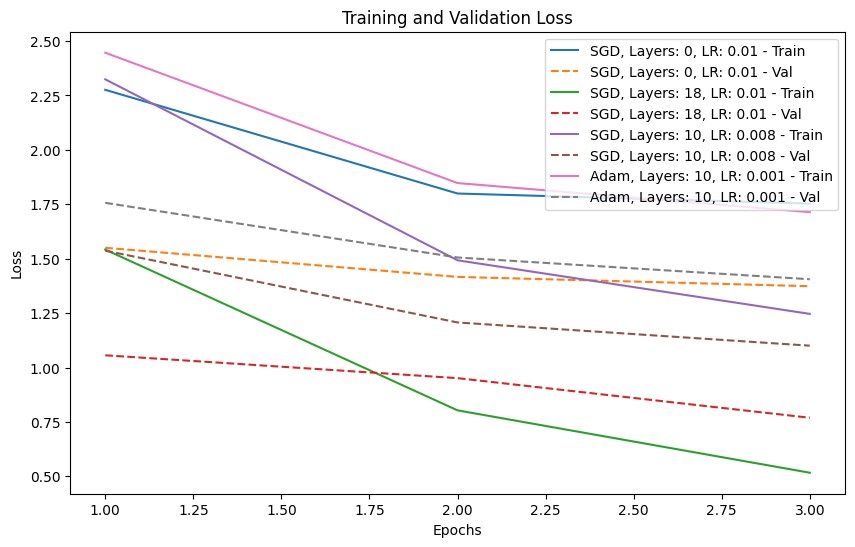

<Figure size 640x480 with 0 Axes>

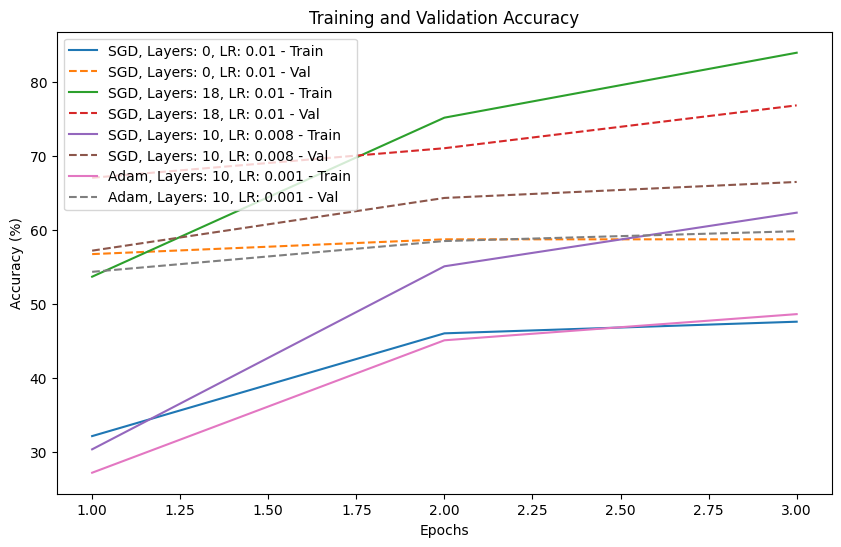

<Figure size 640x480 with 0 Axes>

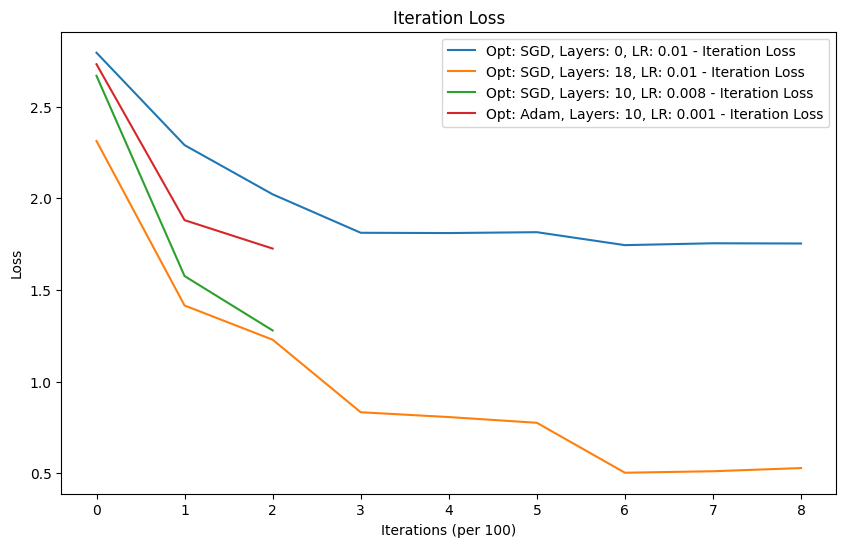

<Figure size 640x480 with 0 Axes>

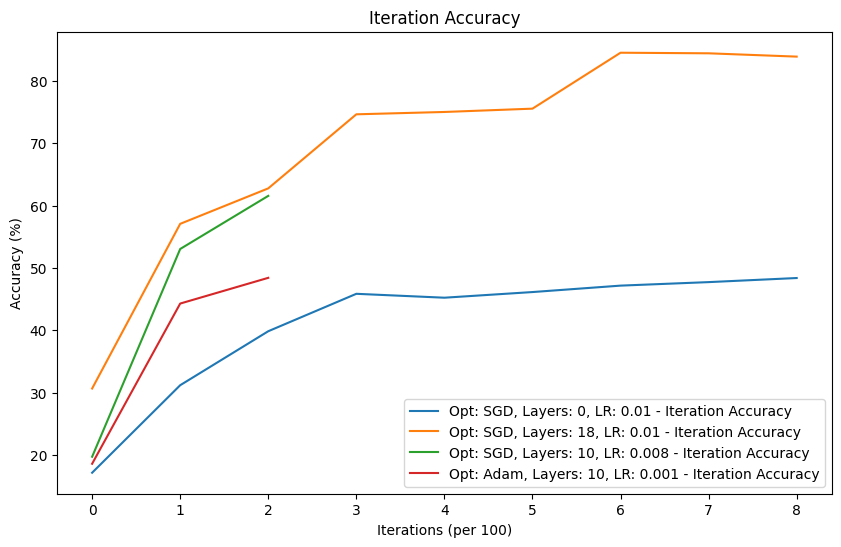

<Figure size 640x480 with 0 Axes>

In [114]:
combined_experiment_results = experiment_results + experiment_results_2
plot_combined_experiment_results(combined_experiment_results)

## Fine Tuning

In [80]:
learning_rates = [0.01, 0.008, 0.001]
batch_sizes = [32, 64, 64]
epochs_list = [6, 10, 10] # increase epochs
momentum_list = [0.5, 0.4, 0]
layers_to_unfreeze = [18, 10, 10]

best_val = experiment_results_2[0]['best_val_loss']

experiment_results_3 = tune_model(learning_rates, batch_sizes, epochs_list, momentum_list, layers_to_unfreeze, best_val)


Running experiment with lr=0.01, batch_size=32, epochs=6
Using SGD with momentum: 0.5
Unfreezing 18 layers
DataLoaders created successfully
Unfreeze all the layers


  0%|          | 0/6 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.3233, Training accuracy: 31.22%
[Epoch 1, Iteration 200] Training loss: 1.4126, Training accuracy: 57.22%
[Epoch 1, Iteration 300] Training loss: 1.2352, Training accuracy: 63.16%


 17%|█▋        | 1/6 [01:19<06:36, 79.28s/it]


>> Epoch 1, Validation loss: 0.9603, Validation accuracy: 70.97%
[Epoch 2, Iteration 100] Training loss: 0.8188, Training accuracy: 76.00%
[Epoch 2, Iteration 200] Training loss: 0.8395, Training accuracy: 74.56%
[Epoch 2, Iteration 300] Training loss: 0.7884, Training accuracy: 76.44%


 33%|███▎      | 2/6 [02:38<05:16, 79.19s/it]


>> Epoch 2, Validation loss: 0.7896, Validation accuracy: 76.03%
[Epoch 3, Iteration 100] Training loss: 0.5118, Training accuracy: 83.97%
[Epoch 3, Iteration 200] Training loss: 0.5348, Training accuracy: 83.19%
[Epoch 3, Iteration 300] Training loss: 0.5533, Training accuracy: 82.66%


 50%|█████     | 3/6 [03:57<03:57, 79.01s/it]


>> Epoch 3, Validation loss: 0.8599, Validation accuracy: 75.10%
[Epoch 4, Iteration 100] Training loss: 0.3089, Training accuracy: 90.38%
[Epoch 4, Iteration 200] Training loss: 0.3057, Training accuracy: 90.88%
[Epoch 4, Iteration 300] Training loss: 0.3250, Training accuracy: 90.09%


 67%|██████▋   | 4/6 [05:16<02:37, 78.95s/it]


>> Epoch 4, Validation loss: 0.8321, Validation accuracy: 76.10%
[Epoch 5, Iteration 100] Training loss: 0.1828, Training accuracy: 94.53%
[Epoch 5, Iteration 200] Training loss: 0.2082, Training accuracy: 93.66%
[Epoch 5, Iteration 300] Training loss: 0.1924, Training accuracy: 94.59%


 83%|████████▎ | 5/6 [06:34<01:18, 78.82s/it]


>> Epoch 5, Validation loss: 0.8452, Validation accuracy: 76.77%
[Epoch 6, Iteration 100] Training loss: 0.1146, Training accuracy: 96.78%
[Epoch 6, Iteration 200] Training loss: 0.0992, Training accuracy: 97.78%
[Epoch 6, Iteration 300] Training loss: 0.1146, Training accuracy: 96.44%


100%|██████████| 6/6 [07:53<00:00, 78.92s/it]


>> Epoch 6, Validation loss: 0.8404, Validation accuracy: 77.97%


Running experiment with lr=0.008, batch_size=64, epochs=10
Using SGD with momentum: 0.4
Unfreezing 10 layers
DataLoaders created successfully
Freeze all but the last n layers



  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.6135, Training accuracy: 22.03%


 10%|█         | 1/10 [01:15<11:20, 75.60s/it]


>> Epoch 1, Validation loss: 1.5058, Validation accuracy: 59.00%
[Epoch 2, Iteration 100] Training loss: 1.5593, Training accuracy: 52.73%


 20%|██        | 2/10 [02:31<10:04, 75.53s/it]


>> Epoch 2, Validation loss: 1.2078, Validation accuracy: 64.37%
[Epoch 3, Iteration 100] Training loss: 1.2642, Training accuracy: 62.41%


 30%|███       | 3/10 [03:46<08:48, 75.51s/it]


>> Epoch 3, Validation loss: 1.1116, Validation accuracy: 65.67%
[Epoch 4, Iteration 100] Training loss: 1.1450, Training accuracy: 65.64%


 40%|████      | 4/10 [05:02<07:34, 75.71s/it]


>> Epoch 4, Validation loss: 1.0282, Validation accuracy: 68.13%
[Epoch 5, Iteration 100] Training loss: 1.0090, Training accuracy: 69.62%


 50%|█████     | 5/10 [06:18<06:18, 75.74s/it]


>> Epoch 5, Validation loss: 0.9850, Validation accuracy: 69.33%
[Epoch 6, Iteration 100] Training loss: 0.9583, Training accuracy: 70.61%


 60%|██████    | 6/10 [07:33<05:02, 75.54s/it]


>> Epoch 6, Validation loss: 0.9519, Validation accuracy: 70.70%
[Epoch 7, Iteration 100] Training loss: 0.8780, Training accuracy: 73.39%


 70%|███████   | 7/10 [08:49<03:46, 75.56s/it]


>> Epoch 7, Validation loss: 0.9337, Validation accuracy: 71.17%
[Epoch 8, Iteration 100] Training loss: 0.8095, Training accuracy: 74.19%


 80%|████████  | 8/10 [10:04<02:31, 75.65s/it]


>> Epoch 8, Validation loss: 0.9183, Validation accuracy: 71.73%
[Epoch 9, Iteration 100] Training loss: 0.7882, Training accuracy: 75.97%


 90%|█████████ | 9/10 [11:20<01:15, 75.67s/it]


>> Epoch 9, Validation loss: 0.8955, Validation accuracy: 72.13%
[Epoch 10, Iteration 100] Training loss: 0.6991, Training accuracy: 78.16%


100%|██████████| 10/10 [12:36<00:00, 75.65s/it]


>> Epoch 10, Validation loss: 0.9016, Validation accuracy: 71.83%


Running experiment with lr=0.001, batch_size=64, epochs=10
Using Adam
Unfreezing 10 layers
DataLoaders created successfully
Freeze all but the last n layers



  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1, Iteration 100] Training loss: 2.7635, Training accuracy: 17.72%


 10%|█         | 1/10 [01:15<11:21, 75.72s/it]


>> Epoch 1, Validation loss: 1.7767, Validation accuracy: 53.27%
[Epoch 2, Iteration 100] Training loss: 1.9063, Training accuracy: 43.20%


 20%|██        | 2/10 [02:32<10:10, 76.35s/it]


>> Epoch 2, Validation loss: 1.5032, Validation accuracy: 58.63%
[Epoch 3, Iteration 100] Training loss: 1.7256, Training accuracy: 48.59%


 30%|███       | 3/10 [03:48<08:53, 76.18s/it]


>> Epoch 3, Validation loss: 1.4154, Validation accuracy: 59.03%
[Epoch 4, Iteration 100] Training loss: 1.6510, Training accuracy: 50.23%


 40%|████      | 4/10 [05:03<07:34, 75.82s/it]


>> Epoch 4, Validation loss: 1.3584, Validation accuracy: 60.33%
[Epoch 5, Iteration 100] Training loss: 1.6112, Training accuracy: 52.02%


 50%|█████     | 5/10 [06:19<06:18, 75.63s/it]


>> Epoch 5, Validation loss: 1.3105, Validation accuracy: 62.07%
[Epoch 6, Iteration 100] Training loss: 1.5860, Training accuracy: 52.23%


 60%|██████    | 6/10 [07:34<05:01, 75.49s/it]


>> Epoch 6, Validation loss: 1.3156, Validation accuracy: 61.23%
[Epoch 7, Iteration 100] Training loss: 1.6233, Training accuracy: 50.80%


 70%|███████   | 7/10 [08:50<03:46, 75.57s/it]


>> Epoch 7, Validation loss: 1.2991, Validation accuracy: 61.70%
[Epoch 8, Iteration 100] Training loss: 1.6438, Training accuracy: 50.94%


 80%|████████  | 8/10 [10:05<02:31, 75.64s/it]


>> Epoch 8, Validation loss: 1.3021, Validation accuracy: 62.10%
[Epoch 9, Iteration 100] Training loss: 1.6038, Training accuracy: 52.34%


 90%|█████████ | 9/10 [11:22<01:15, 75.88s/it]


>> Epoch 9, Validation loss: 1.2857, Validation accuracy: 62.50%
[Epoch 10, Iteration 100] Training loss: 1.6115, Training accuracy: 51.03%


100%|██████████| 10/10 [12:39<00:00, 75.92s/it]


>> Epoch 10, Validation loss: 1.2790, Validation accuracy: 61.70%




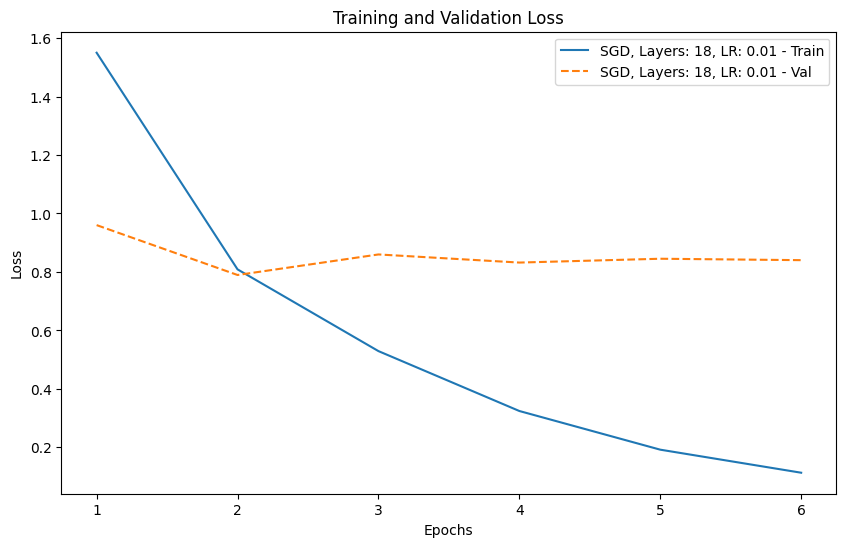

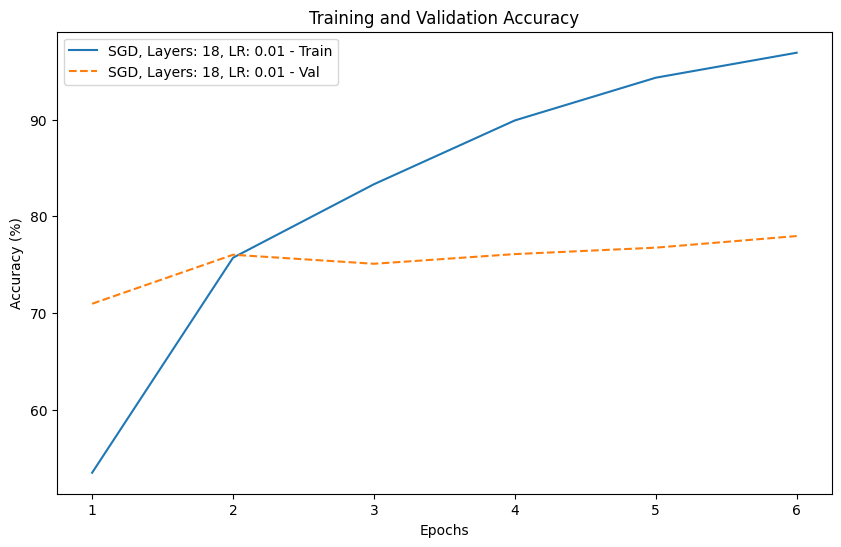

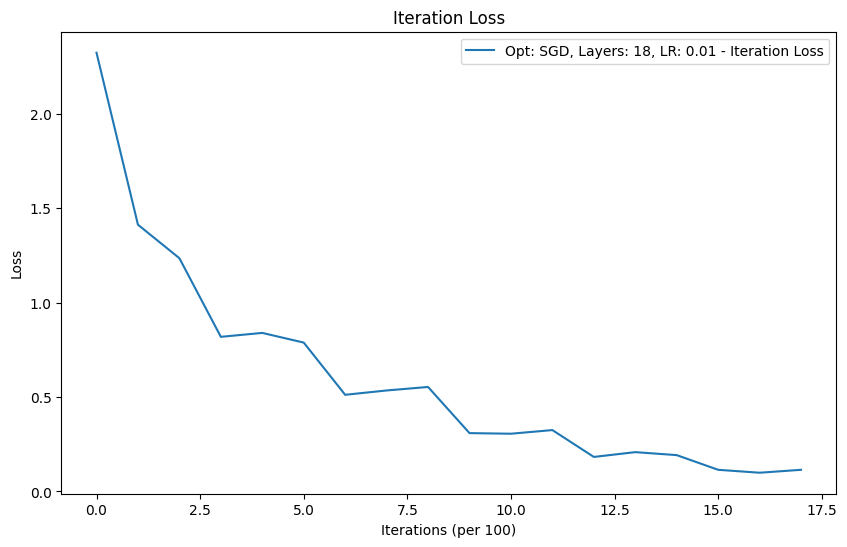

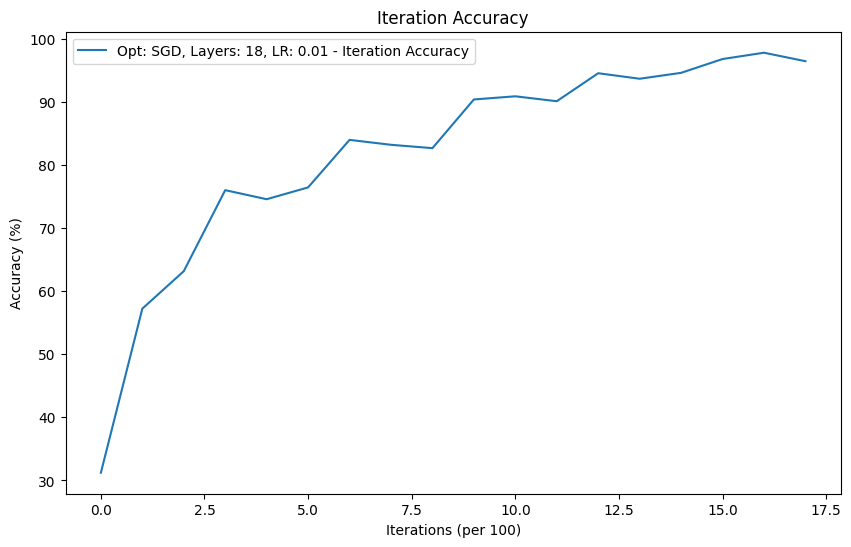

In [102]:
plot_combined_experiment_results([experiment_results_3[0]])

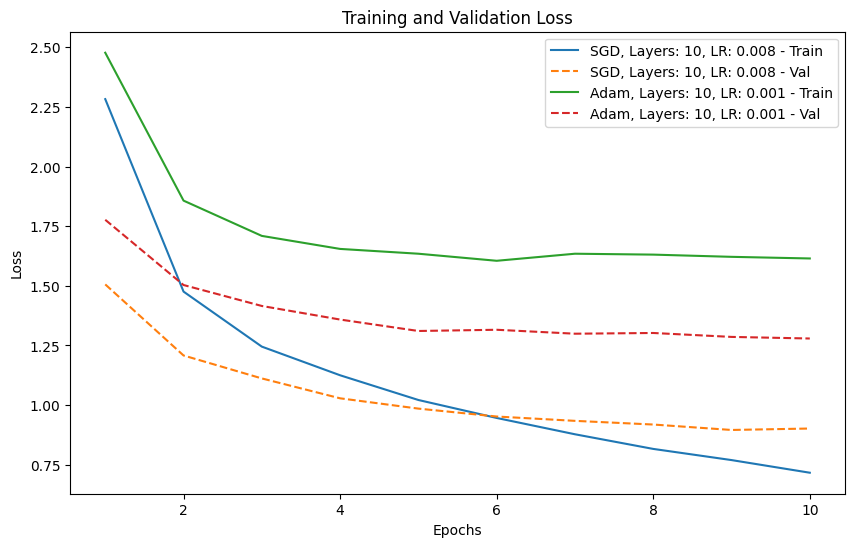

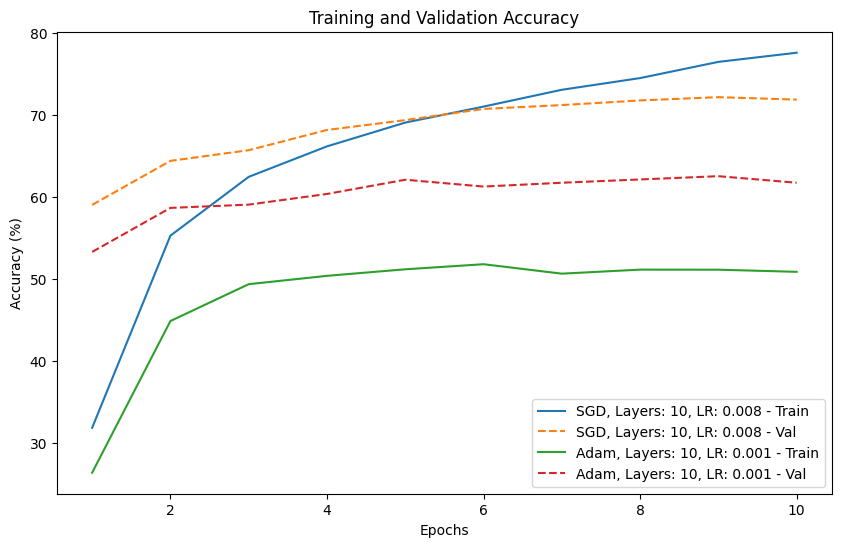

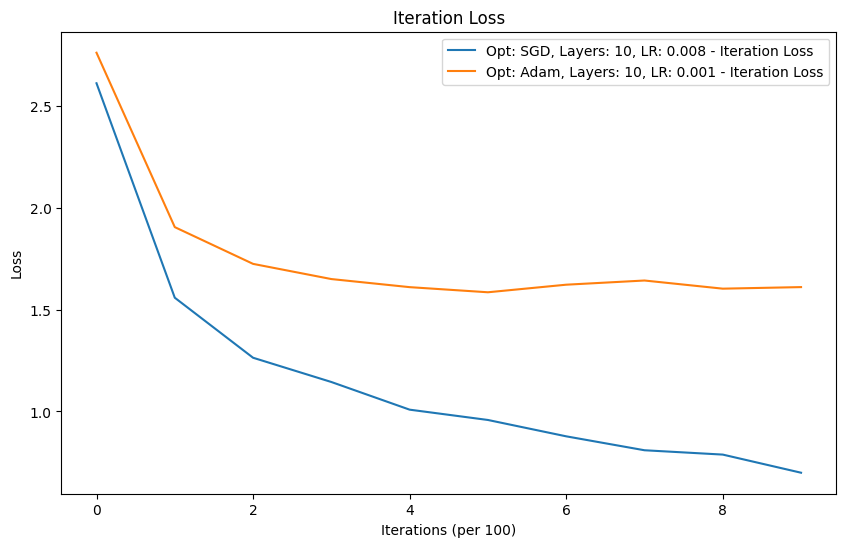

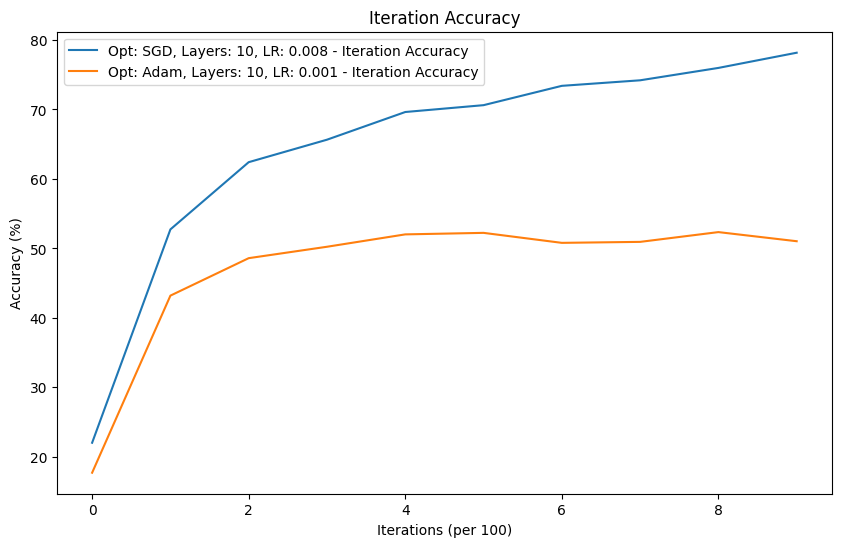

In [106]:
model_results = [experiment_results_3[1]] + [experiment_results_3[2]]
plot_combined_experiment_results(model_results)

### Verdict/Insights

* Unable to beat the previous model.
* Increasing epochs for the first model is resulting in high training accuracy/low training loss, but stagnant validation accuracy/loss. This shows the model is memorizing the training data.
* SGD is a real difference maker here, Adam is performing very poorly.

# Evaluation of the Best Model

* Using SGD with momentum: 0.5
* Unfreezing 18 layers
* 3 epochs
* Batch size of 32
* Learning rate of 0.01


## Metrics for the Best Model (Validation Set)

In [81]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return all_preds, all_labels


In [82]:
model = initialize_model(18)
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

Unfreeze all the layers


In [83]:
all_preds, all_labels = calculate_metrics(model, valloader, device)

Accuracy: 0.7687
Precision: 0.7757
Recall: 0.7687
F1-Score: 0.7669


## Visualizing Predictions and Misclassifications (Validation Set)

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor, mean, std):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_predictions(model, dataloader, device, classes, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {classes[preds[j]]}, Actual: {classes[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return


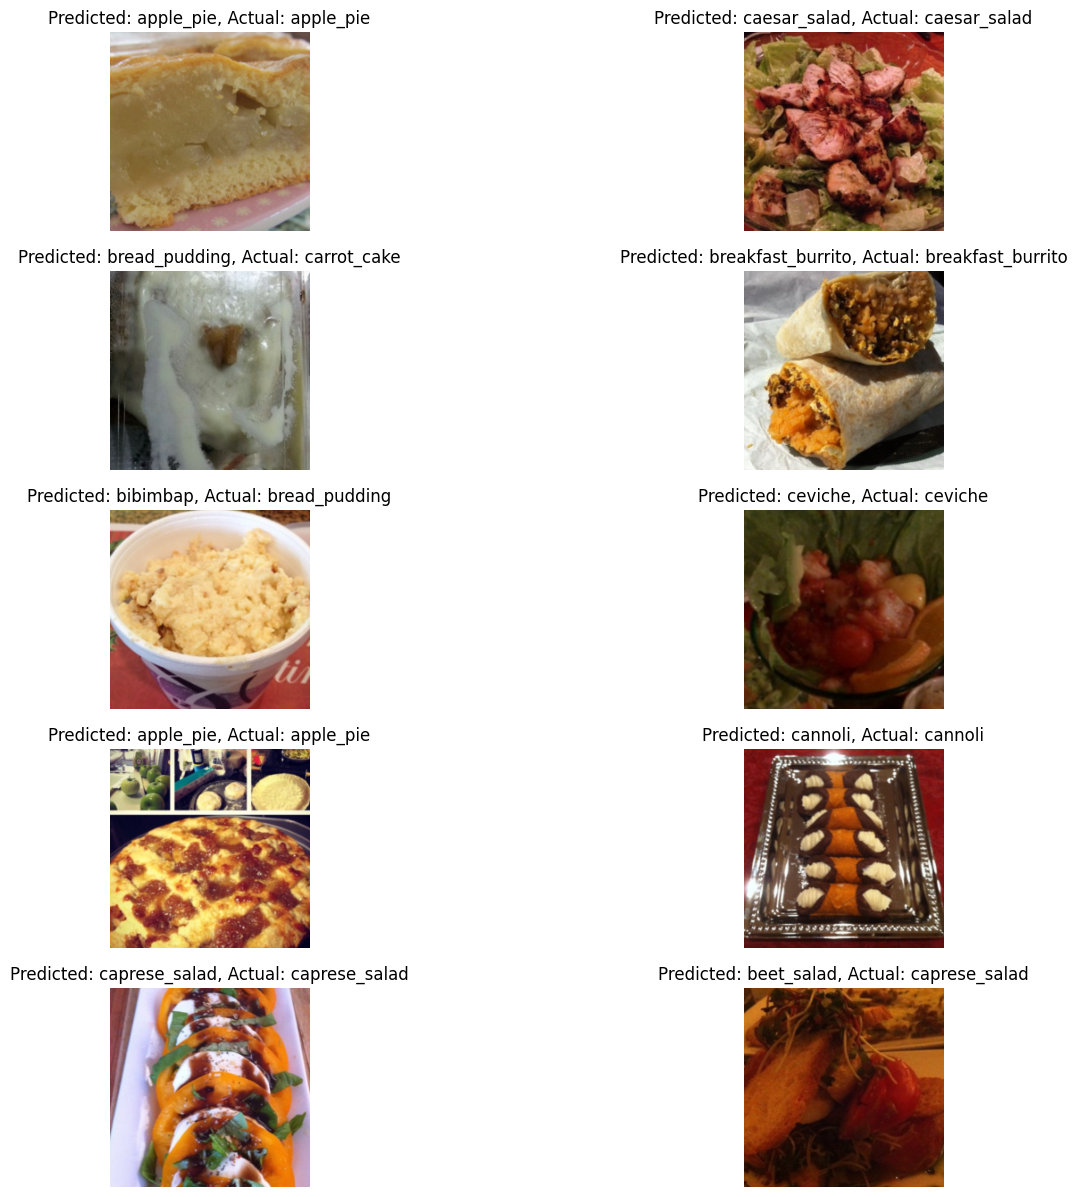

In [88]:
classes = classes_to_keep
visualize_predictions(model, valloader, device, classes, num_images=10)


# Final Model Testing (Test Data)


In [89]:
all_preds_test, all_labels_test = calculate_metrics(model, testloader, device)

Accuracy: 0.8005
Precision: 0.8056
Recall: 0.8005
F1-Score: 0.7979


In [108]:
test_results = pd.DataFrame({'Predicted': all_preds_test, 'Actual': all_labels_test})
test_results

,Predicted,Actual
0,3,3
1,14,9
2,16,16
3,6,6
4,7,7
...,...,...
1995,3,3
1996,4,4
1997,17,17
1998,12,14


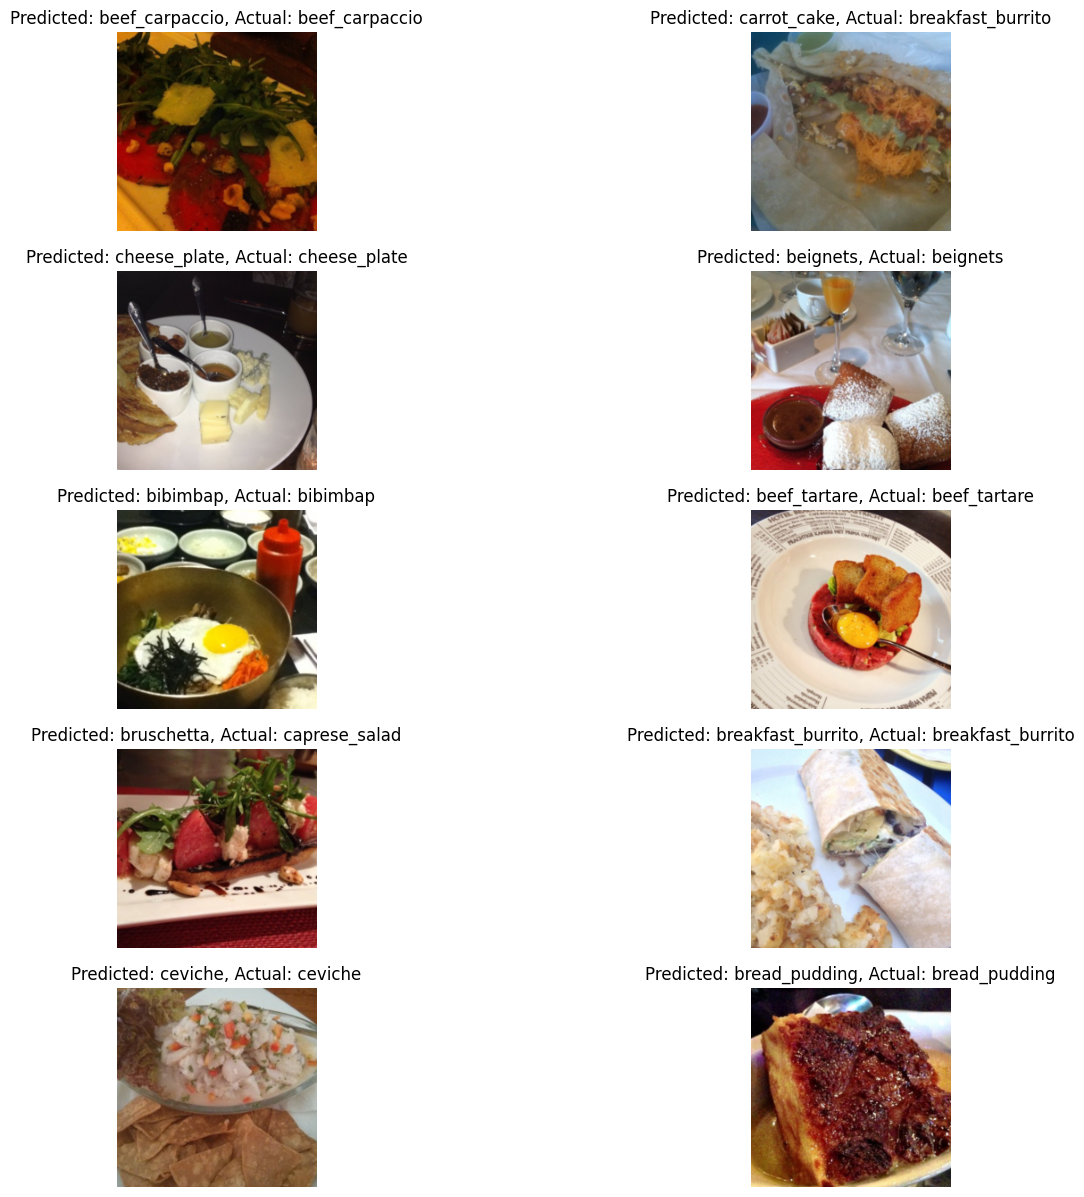

In [90]:
visualize_predictions(model, testloader, device, classes, num_images=10)